# Text Classification using SciKit Learn

We will use the cleaned version of the covid tweets `TweetC_train.csv` and `TweetC_test.csv` to fit and test classic Machine Learning models.

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier

from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

import optuna
import xgboost as xgb
import seaborn as sns


In [2]:
train_data = pd.read_csv('Data/TweetC_train.csv')
test_data = pd.read_csv('Data/TweetC_test.csv')
print(f'Training obs: {train_data.shape[0]}, and testing obs: {test_data.shape[0]}')

Training obs: 41156, and testing obs: 3798


In [3]:
train_data.head()

,Corpus,label
0,advice talk neighbour family exchange phone nu...,4
1,coronavirus australia woolworth elderly disabl...,4
2,food stock panic food need stay calm stay safe,4
3,ready supermarket outbreak paranoid food stock...,0
4,news regionâs confirmed covid case came sulli...,4


In [4]:
# dropping indexes with nan

# training set
index_with_nan = train_data.index[train_data.isnull().any(axis=1)]
train_data.drop(index_with_nan,0, inplace=True)

# testing set
index_with_nan = test_data.index[test_data.isnull().any(axis=1)]
test_data.drop(index_with_nan,0, inplace=True)

In [5]:
# we have no nans left
pd.isna(train_data).sum(), pd.isna(test_data).sum()

(Corpus    0
 label     0
 dtype: int64, Corpus    0
 label     0
 dtype: int64)

In [6]:
# split text and labels

# text
text_train = train_data.iloc[:,0].copy().to_numpy()
text_test = test_data.iloc[:,0].copy().to_numpy()

# labels
y_train = train_data.iloc[:,1].copy().to_numpy()
y_test = test_data.iloc[:,1].copy().to_numpy()

y_train = y_train.astype('int')
y_test = y_test.astype('int')

We have already cleaned and removed all tweetws related signs that are not good for the analysis. We see that we have stayed only with the text and the sentiment class in an encoded version. 

`Extremely Negative`: 0

`Extremely Positive`: 1

`Negative`: 2

`Neutral`: 3

`Positive`: 4

## Apply vectorization with the `tf-idf` method provided from sklearn 

In [7]:
# assigning the class to tfidf
tfidf = TfidfVectorizer(max_features=4000, max_df=0.8, sublinear_tf=True, min_df=10, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')

# applying the vectorizer to the training data
X_train = tfidf.fit_transform(text_train).toarray()
X_test = tfidf.transform(text_test).toarray()

In [8]:
X_train.shape, X_test.shape

((41087, 4000), (3795, 4000))

We can see that after applying the vectorization provided from sklearn `tf-idf`, we have created a matrix with 13484 columns, representing each word present in the documents. This is a very sparse matrix for both the train and test documents. 

## Optimizing number of max features to consider in TF-IDF vectorization


In [9]:
# calculating the optimal number of max features to consider:

accs = {k:0 for k in range(500, 8000, 250)}
for f in tqdm(range(500, 8000, 250)):

    # assigning the class to tfidf
    tfidf = TfidfVectorizer(max_features=f, max_df=0.8, sublinear_tf=True, min_df=10, norm='l2',             encoding='latin-1', ngram_range=(1, 3), stop_words='english')

    # applying the vectorizer to the training data
    X_train = tfidf.fit_transform(text_train).toarray()

    X_test = tfidf.transform(text_test).toarray()

    svm_model = LinearSVC(C=0.1)
    svm_model.fit(X_train, y_train)

    accs[f] = svm_model.score(X_test, y_test)


100%|██████████| 30/30 [03:52<00:00,  7.74s/it]


In [10]:
# features and max value
max(accs, key=accs.get), accs[max(accs, key=accs.get)]

(3000, 0.5322793148880105)

## Appliying the vectorization with that max. number of features

In [9]:
max_features = 3000 # max(accs, key=accs.get)
tfidf = TfidfVectorizer(max_features=max_features, max_df=0.8, sublinear_tf=True, min_df=10, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')

# applying the vectorizer to the training data
X_train = tfidf.fit_transform(text_train).toarray()
X_test = tfidf.transform(text_test).toarray()

We will use the chi2 function from sklearn to get the most common words per category.

In [10]:
labels = {'Extremely Negative': 0,
          'Extremely Positive': 1,
          'Negative': 2,
          'Neutral': 3,
          'Positive': 4}

In [11]:
N = 2
for category, id in labels.items():
    features_chi2 = chi2(X_train, y_train == id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    # single words
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    # pair of words
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    # three words
    trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
    print('\n**',category,'\n')
    print("  +Most correlated unigrams:\n   -{}".format('\n   -'.join(unigrams[-N:])))
    print("  +Most correlated bigrams:\n   -{}".format('\n   -'.join(bigrams[-N:])))
    print("  +Most correlated trigrams:\n   -{}".format('\n   -'.join(trigrams[-N:])))


** Extremely Negative 

  +Most correlated unigrams:
   -panic
   -crisis
  +Most correlated bigrams:
   -stop panic
   -panic buying
  +Most correlated trigrams:
   -people panic buying
   -stop panic buying

** Extremely Positive 

  +Most correlated unigrams:
   -best
   -great
  +Most correlated bigrams:
   -stay safe
   -hand sanitizer
  +Most correlated trigrams:
   -thank grocery store
   -health care worker

** Negative 

  +Most correlated unigrams:
   -hand
   -demand
  +Most correlated bigrams:
   -oil price
   -hand sanitizer
  +Most correlated trigrams:
   -low oil price
   -falling oil price

** Neutral 

  +Most correlated unigrams:
   -like
   -panic
  +Most correlated bigrams:
   -panic buying
   -hand sanitizer
  +Most correlated trigrams:
   -panic buying food
   -stop panic buying

** Positive 

  +Most correlated unigrams:
   -hand
   -panic
  +Most correlated bigrams:
   -panic buying
   -hand sanitizer
  +Most correlated trigrams:
   -sanitizer italy wuhan
   -g

## Fitting a linear SVM

In [14]:
# applying an SVM model to it
svm = LinearSVC()

params = {'C': [0.01, 0.1, 1, 10, 100]}

svm_model = GridSearchCV(svm, params)

svm_model.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='warn', n_jobs=None, param_grid={'C': [0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [15]:
svm_model.best_params_

{'C': 1}

In [12]:
# training the model with the best params found in the HPO part above:
svm_model = LinearSVC(C=1)
svm_model.fit(X_train, y_train)

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [13]:
svm_model.score(X_test, y_test)

0.5346508563899868

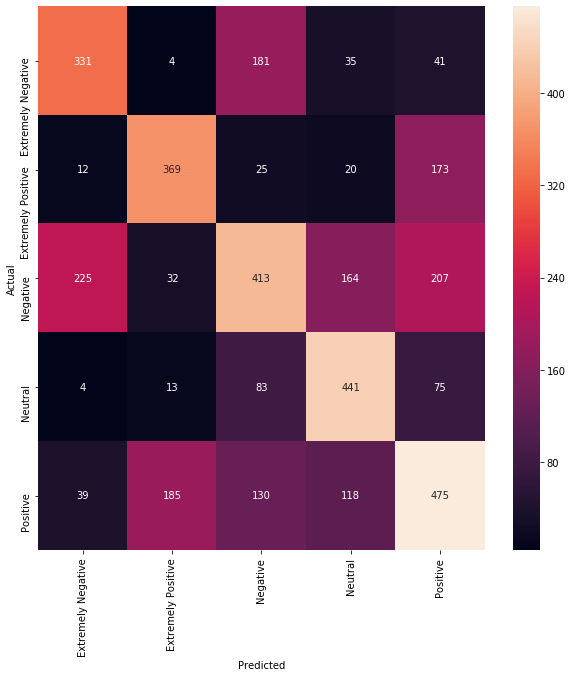

In [14]:
y_pred = svm_model.predict(X_test)

# generate the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labels.keys(), yticklabels=labels.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

We have seen that with a basic Linear SVM we get an accuracy of 0.52, we have set this accuracy with `n-grams` of one, two and three word combinations. 

## Hyper Parameter Opt. different models

## SVM HPO

Training with an rbf kernel never finishes, since the number of operations for this size of the matrix is simply huge, traied for 10hours straight and still didnt finish. While the linear one finishes in seconds.

with max 100 components it did, but the accuracy obtained with it is way lower.
**Trying PCA decomposition**

In [18]:
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X_train)
Xtest_pca = pca.transform(X_test)
X_pca.shape, Xtest_pca.shape

((41087, 100), (3795, 100))

In [19]:
svc= LinearSVC()
svc.fit(X_pca, y_train)
svc.score(Xtest_pca, y_test)

0.3691699604743083

## Logistic Regression

In [15]:
# simple lr with saga solver takes waay more time and gives the same result
lr = LogisticRegression() #solver='saga')
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.5346508563899868

hyper parameter tunning C

In [58]:
# optimizing its parameters
params = {'C' : [1, 10, 25, 30]}

lr_model = RandomizedSearchCV(lr, params, cv=kfolds, n_jobs = -1)

lr_model.fit(X_train, y_train)
lr_model.best_params_

{'C': 25}

In [16]:
# fitting the logistic regression with the parameters found in the HPO stage

lr_model = LogisticRegression(C=25)
lr_model.fit(X_train, y_train)

LogisticRegression(C=25, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
lr_model.score(X_test, y_test)

0.5499341238471673

## Xgboost + Optuna

This process takes waay to long time to complete and it does not deliver good results, left for a whole night running it.

In [ ]:
# optimizing its parameters

def objective(trial):
    rf_opt = xgboost.set_params( learning_rate=trial.suggest_float("learning_rate", 0.01,0.2),
                   subsample = trial.suggest_categorical("subsample", [0.4,0.5,0.6,0.7,0.75,0.8,0.85]),
                   gamma = trial.suggest_float("gamma", 0, 0.4),
                   min_child_weight = trial.suggest_int("min_child_weight",1,10),
                   reg_alpha = trial.suggest_categorical("reg_alpha", [0, 0.001, 0.005, 0.01, 0.05]))
    
    scores = cross_val_score(rf_opt, X_train, y_train, 
                              scoring='accuracy', 
                              n_jobs=2,
                              cv=kfold)
    return scores.mean() 

np.random.seed(0)
rf_optuna = optuna.create_study(direction="maximize")
rf_optuna.optimize(objective, n_trials=20, n_jobs=4)

## Naive Bayes

Using gaussian naive bayes

In [46]:
# simple gaussian naive bayes model
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb.score(X_test, y_test)

0.35046113306982873

Using Multinomial Naive Bayes

In [19]:
# multinomial naive bayes model
gnb = MultinomialNB()

params = {'alpha': [1e-6, 1e-5, 1e-4, 1e-2, 1]}

gnb_model = RandomizedSearchCV(gnb, params, cv=4, n_jobs = -1)

gnb_model.fit(X_train, y_train)

RandomizedSearchCV(cv=4, error_score='raise-deprecating',
                   estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                           fit_prior=True),
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'alpha': [1e-06, 1e-05, 0.0001, 0.01,
                                                  1]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [20]:
gnb_model.score(X_test, y_test), gnb_model.best_params_

(0.4455862977602108, {'alpha': 0.01})

In [38]:
# fitting the model with the parameters found above:

mnb_model = MultinomialNB(alpha=0.01)
mnb_model.fit(X_train, y_train)
mnb_model.score(X_test, y_test)

0.4455862977602108

## Random Forest Classifier

### Optimizing the HP

In [47]:
params = {'max_depth': [128,256, 400, 600],
          'min_samples_split': [50,100,200,400],
          'min_samples_leaf': [2,10]}
rf = RandomForestClassifier()

rf_model = RandomizedSearchCV(rforest, params, cv = 3)
rf_model.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=128,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=10,
                                                    n_jobs=None,
   

In [48]:
rf_model.score(X_test, y_test)

0.4706192358366271

In [46]:
rf_model.best_params_

{'min_samples_split': 100, 'min_samples_leaf': 2, 'max_depth': 256}

In [22]:
# fitting the RF classifier with the HP found with the optimization above
rf_model = RandomForestClassifier(min_samples_split= 100, min_samples_leaf= 2, max_depth= 256)
rf_model.fit(X_train, y_train)
rf_model.score(X_test, y_test)

0.4666666666666667

## K-Nearest Neighbors

Is not a very well suited algorithm for large datasets, specially if we have, like in our case, 3000 variables. 

In [24]:
knn = KNeighborsClassifier()

params = {'n_neighbors': [2,8]}

knn_model = RandomizedSearchCV(knn, params, cv=4, n_jobs = -1)

knn_model.fit(X_train, y_train)
knn_model.score(X_train, y_test)

KeyboardInterrupt: 

## Getting the Performance Metrics for all the models

The classic ML models that we have tried so far, along with the opimized HP

*   Support Vector Machine:

        - C: 1

*   Logistic Regression:

        - C: 25

*   Gaussian Naive Bayes

*   Multinomial Naive Bayes:

        - alpha: 1e-6

*   Random Forest:

        - min_samples_split: 100

        - min_samples_leaf': 2

        - 'max_depth': 256

*   K-Nearest Neighbors:



In [47]:
models = {'SVM': svm_model,
          'Logit': lr_model,
          'GaussianNB': gnb,
          'MultiNB': mnb_model,
          'RandomForest': rf_model}

In [ ]:
labels = {'Extremely Negative': 0,
          'Extremely Positive': 1,
          'Negative': 2,
          'Neutral': 3,
          'Positive': 4}

In [52]:
labels.keys()

dict_keys(['Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral', 'Positive'])

In [53]:
# looping through the optimized models and getting all the accuracy metrics
for model_name, model in models.items():
    print('Classification Report of ', model_name, '\n')
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, target_names= labels.keys()))
    print('------------\n')


Classification Report of  SVM 

                    precision    recall  f1-score   support

Extremely Negative       0.54      0.56      0.55       592
Extremely Positive       0.61      0.62      0.61       599
          Negative       0.50      0.40      0.44      1041
           Neutral       0.57      0.72      0.63       616
          Positive       0.49      0.50      0.50       947

          accuracy                           0.53      3795
         macro avg       0.54      0.56      0.55      3795
      weighted avg       0.53      0.53      0.53      3795

------------

Classification Report of  Logit 

                    precision    recall  f1-score   support

Extremely Negative       0.56      0.56      0.56       592
Extremely Positive       0.66      0.63      0.64       599
          Negative       0.50      0.41      0.45      1041
           Neutral       0.59      0.69      0.64       616
          Positive       0.50      0.56      0.53       947

          accur